Created: 2/11/2020 - Ryan Corbyn 

Description: 

The aim of this program is to take the data recorded from the 11 point ODMR measurement and compare it to the CW ODMR data-set from which the 11-point scan program was created. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plot 
import scipy.optimize as opt
import os

In [2]:
def get_11_point_scan_freqs(file_name):
    # Open the file containing the frequency scan parameters
    frequency_scan = pd.read_table(file_name, names = ['Frequency (Hz)', 'Power (dBm)'])
    return(frequency_scan)

In [3]:
def get_11_point_ODMR_data(odmr_11_point_file):
    # get the 11 point ODMR data from the .dat file. 
    odmr_11_point_data = pd.read_table(odmr_11_point_file, names = ['0', '1', '2', '3',
                                                                   '4', '5', '6', '7', 
                                                                   '8', '9', '10', '11'])
    del odmr_11_point_data['11']
    
    return(odmr_11_point_data)

In [4]:
def load_CW_ODMR_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [5]:
def load_CW_ODMR_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [6]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    
    return(freq)

In [7]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data =  np.mean(odmr_data, axis=0)
    return(mean_odmr_data)

In [21]:
def normalise_data(mean_odmr_data):
    # normalise the data to the maximum value of the mean dataset. 
    norm_odmr_data = mean_odmr_data/(np.mean(mean_odmr_data))
    return(norm_odmr_data)

In [9]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    ax2.set_xlim(np.min(freq),np.max(freq))
    return(fig2, ax2)

In [10]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    half_data_length = int((len(freq)-1)/2)
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate contrast for ODMR peaks
    contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
                np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, contrast, flourescent_baseline)

In [11]:
def optimised_lorentz_fit(freq, mean_data, init_params):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, sigma = y_error)
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [12]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [13]:
def plot_fitting(ax2, freq, y_fit):
    # plot the y fit. 
    
    ax2.plot(freq, y_fit, color='k', label='Double Lorentz \nfitting')
    ax2.legend(loc = 'lower right')
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts', fontsize = 18)
    
    return(ax2)

In [39]:
def plot_11_scatter_points(ax3, freq, intensity, label, marker, color):
    # A method to plot the 11 frequnecy points 
    ax3.scatter(freq, intensity, label = label, marker = marker, color = color)
    ax3.legend(loc= 'lower center')
    #ax3.set_ylim(min(intensity)-0.02, max(intensity) + 0.01)
    ax3.set_xlim(min(freq), max(freq))
    return(ax3)

In [15]:
def save_graphs_and_data(date, ODMR_name, fig):
    # save all relavent information
    save_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\ODMR\\' + date + '\\'
    
    
      # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
        # Checking the output file exists and creating and initialising it if not
        
    fig.savefig(save_folder + ODMR_name + '_11_point_comp_graph'+'.png')
    fig.savefig(save_folder +  ODMR_name + '_11_point_comp_graph'+'.pdf')

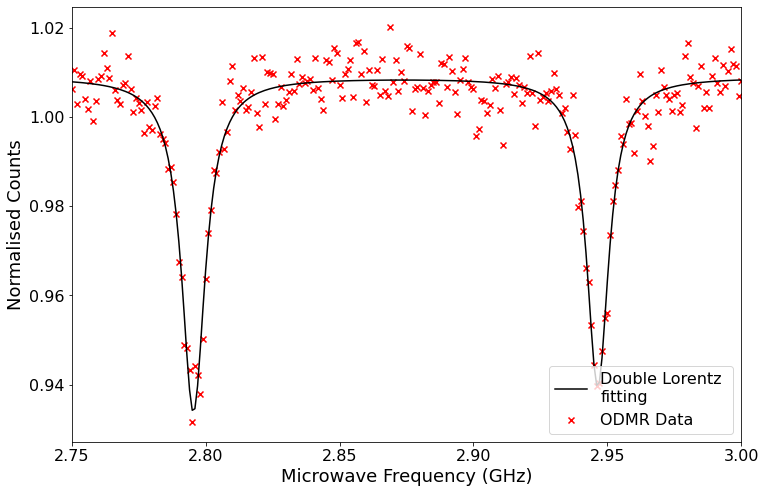

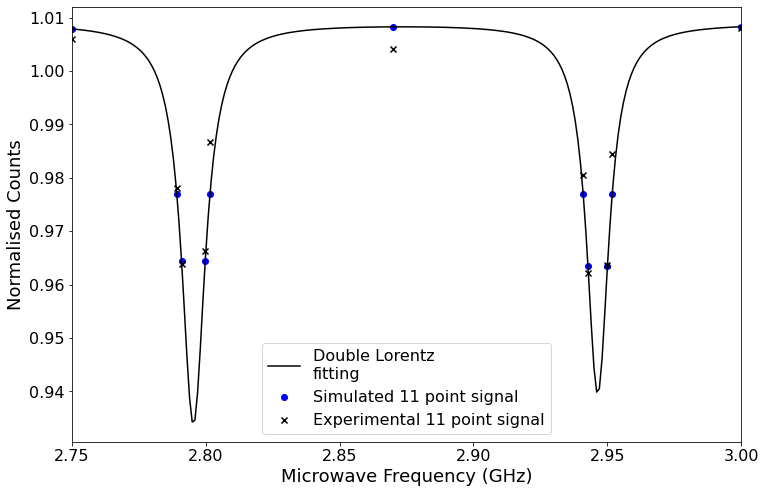

In [73]:
## This is the code for CW 11 point ODMR analysis

# set the folder location
folder_location = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
date = '20201030'
# Set the name of the frequnecy scan text file. 
frequnecy_11_points_scan_name = date + '\\' + date + '_11 thermometery_points_' + date + '_NVScan_14'
# Generate the frequency scan array. 
frequency_11_points_scan = get_11_point_scan_freqs(folder_location + frequnecy_11_points_scan_name + '.txt')
frequency_11_points = frequency_11_points_scan['Frequency (Hz)']*(10**-9)

# Set the name of the 11 point ODMR scan. 

odmr_11_point_file_name = date + '_NVScan_18'
odmr_11_point_data = get_11_point_ODMR_data(folder_location +  date + '\\' + odmr_11_point_file_name + '.dat')

# Set the name of the CW ODMR data set. 

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
file_name = date + '\\' + date + '_NVScan_14'
odmr_data = load_CW_ODMR_data(folder_location +  file_name + '.dat')
params_file = load_CW_ODMR_params(folder_location + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])
# find the mean of the ODMR data
mean_odmr_data = mean_data(odmr_data)
# Normalise the dataset
norm_mean_odmr = normalise_data(mean_odmr_data)

# scatter plot of data
fig2, ax2 = scatter_plot(freq, norm_mean_odmr)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, contrast, flourescent_baseline = get_init_params(norm_mean_odmr, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [contrast[0], freq_mins[0], 0.001, contrast[1], freq_mins[1], 0.001, flourescent_baseline]
#init_params = [contrast[0], 2.78, 0.001, contrast[1], 2.96, 0.001, flourescent_baseline]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, norm_mean_odmr, init_params)

# create the double lorentz fit array
y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
# Generate the 11 points used to generate the list for the 11 point scan. 
y_fit_11_points = double_lorentz(frequency_11_points, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])

# plot the fitting to ax2
ax2 = plot_fitting(ax2, freq, y_fit)
# Plot the lorentz fitting and the 11 points simulated and 
# the 11 points form the ODMR measurement. 
fig3, ax3 = plot.subplots()
ax3 = plot_fitting(ax3, freq, y_fit)

ax3 = plot_11_scatter_points(ax3, frequency_11_points, y_fit_11_points, 'Simulated 11 point signal', 'o', 'b' )
ax3 = plot_11_scatter_points(ax3, frequency_11_points, (odmr_11_point_data.mean(axis = 0)/(odmr_11_point_data['10'].mean(axis = 0))+0.008), 
                  'Experimental 11 point signal', 'x','k')

save_graphs_and_data(date, odmr_11_point_file_name, fig3)

In [60]:
def get_lock_in_data(file_path):
    # get the data out from a .dat file into a pandas array.
    data = pd.read_table(file_path)
    return(data)

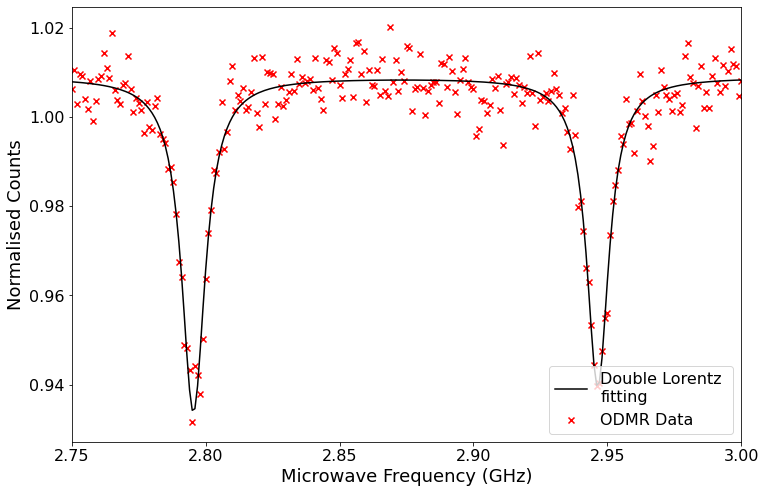

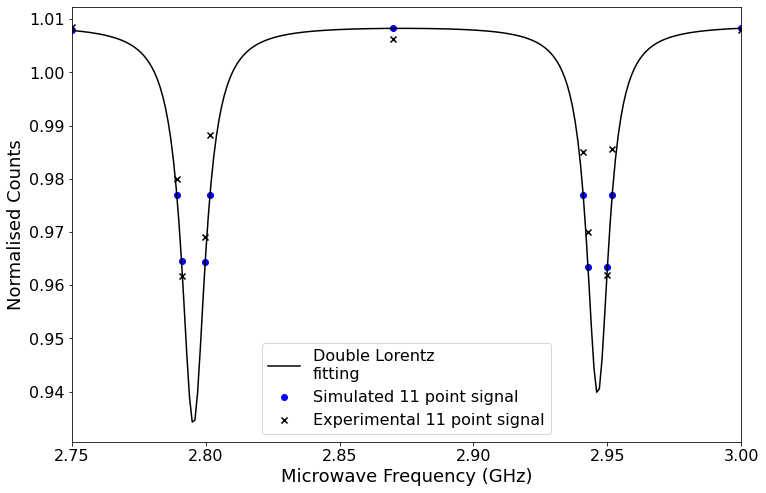

In [77]:
## This is the code for analysing the lock-in 11 point measurement. 

lock_in_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\' + date + '\\' + 'Lock_in_results\\'
lock_in_file_ID = date+'_NVScan_22_lock_in'

lock_in_data = get_lock_in_data(lock_in_folder + lock_in_file_ID + '.dat')

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
file_name = date + '\\' + date + '_NVScan_14'
odmr_data = load_CW_ODMR_data(folder_location +  file_name + '.dat')
params_file = load_CW_ODMR_params(folder_location + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])
# find the mean of the ODMR data
mean_odmr_data = mean_data(odmr_data)
# Normalise the dataset
norm_mean_odmr = normalise_data(mean_odmr_data)

# scatter plot of data
fig2, ax2 = scatter_plot(freq, norm_mean_odmr)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, contrast, flourescent_baseline = get_init_params(norm_mean_odmr, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [contrast[0], freq_mins[0], 0.001, contrast[1], freq_mins[1], 0.001, flourescent_baseline]
#init_params = [contrast[0], 2.78, 0.001, contrast[1], 2.96, 0.001, flourescent_baseline]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, norm_mean_odmr, init_params)

# create the double lorentz fit array
y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
# Generate the 11 points used to generate the list for the 11 point scan. 
y_fit_11_points = double_lorentz(frequency_11_points, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])

# plot the fitting to ax2
ax2 = plot_fitting(ax2, freq, y_fit)
# Plot the lorentz fitting and the 11 points simulated and 
# the 11 points form the ODMR measurement. 
fig3, ax3 = plot.subplots()
ax3 = plot_fitting(ax3, freq, y_fit)

norm_lockin_data = lock_in_data['Lock-in signal (counts per 500.0 $\mu$s)']/lock_in_data['Lock-in signal (counts per 500.0 $\mu$s)'][10]

ax3 = plot_11_scatter_points(ax3, lock_in_data['Frequency (GHz)'], y_fit_11_points, 'Simulated 11 point signal', 'o', 'b' )
ax3 = plot_11_scatter_points(ax3, lock_in_data['Frequency (GHz)'], norm_lockin_data+0.008, 
                  'Experimental 11 point signal', 'x','k')

save_graphs_and_data(date, lock_in_file_ID, fig3)

In [65]:
print(lock_in_data)

    Frequency (GHz)  Lock-in signal (counts per 500.0 $\mu$s)
0          2.750000                                 49.443506
1          2.789227                                 47.426503
2          2.791005                                 47.436222
3          2.799851                                 47.498987
4          2.801629                                 48.507656
5          2.870000                                 49.865850
6          2.940970                                 48.282577
7          2.942748                                 48.080643
8          2.950021                                 47.232789
9          2.951799                                 48.010450
10         3.000000                                 49.961506
